Fetching activities for 2024-05-01...
Fetching activities for 2024-05-02...
Fetching activities for 2024-05-03...
Fetching activities for 2024-05-04...
Fetching activities for 2024-05-05...
Fetching activities for 2024-05-06...
Fetching activities for 2024-05-07...
Fetching activities for 2024-05-08...
Fetching activities for 2024-05-09...
Fetching activities for 2024-05-10...
Fetching activities for 2024-05-11...
Fetching activities for 2024-05-12...
Fetching activities for 2024-05-13...
Fetching activities for 2024-05-14...
Fetching activities for 2024-05-15...
Fetching activities for 2024-05-16...
Fetching activities for 2024-05-17...
Fetching activities for 2024-05-18...
Fetching activities for 2024-05-19...
Fetching activities for 2024-05-20...
Fetching activities for 2024-05-21...
Fetching activities for 2024-05-22...
Fetching activities for 2024-05-23...
Fetching activities for 2024-05-24...
Fetching activities for 2024-05-25...
Fetching activities for 2024-05-26...
Fetching act

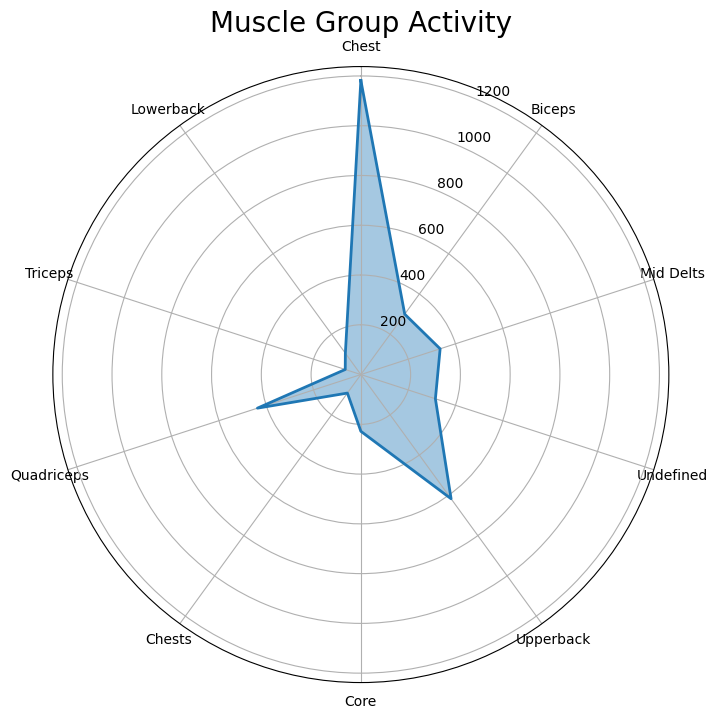

Deprecated: Alternative is to delete login tokens to logout.


Data saved to StrengthTraining_01.05.2024_31.07.2024.csv


In [1]:
import json
import csv
import os
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from garminconnect import Garmin

class ExerciseMapper:
    def __init__(self, mapping_file='exercise_to_muscle_group.csv'):
        self.mapping_file = mapping_file
        self.exercise_to_muscle_group = self._load_mapping()

    def _load_mapping(self):
        if os.path.exists(self.mapping_file):
            return pd.read_csv(self.mapping_file, index_col=0, squeeze=True).to_dict()
        else:
            # Default mapping
            return {
                "BENCH_PRESS": "Chest",
                "PUSH_UP": "Chest",
                "SIT_UP": "Core"
            }

    def save_mapping(self):
        pd.DataFrame.from_dict(self.exercise_to_muscle_group, orient='index', columns=['Muscle Group']).to_csv(self.mapping_file)

    def map_exercises(self, data):
        mapped_data = []
        for exercise in data["summarizedExerciseSets"]:
            category = exercise["category"]
            if category not in self.exercise_to_muscle_group:
                self._add_new_exercise(category)

            muscle_group = self.exercise_to_muscle_group[category]
            mapped_data.append({
                "Muscle Group": muscle_group,
                "Exercise": category,
                "Reps": exercise["reps"],
                "Sets": exercise["sets"]
            })
        return mapped_data

    def _add_new_exercise(self, category):
        print(f"New exercise found: {category}")
        valid_muscle_groups = [
            "Lowerback", "Upperback", "Chests", "Front Delts", "Rear Delts",
            "Mid Delts", "Biceps", "Triceps", "Hamstrings", "Quadriceps", "Abs", "Undefined"
        ]
        print(f"Available muscle groups: {', '.join(valid_muscle_groups)}")
        while True:
            muscle_group = input(f"Please enter the muscle group for {category}: ")
            if muscle_group in valid_muscle_groups:
                break
            print("Invalid muscle group. Please choose from the available options.")

        self.exercise_to_muscle_group[category] = muscle_group
        self.save_mapping()

class GarminDataFetcher:
    def __init__(self, email, password):
        self.client = Garmin(email, password)
        self.client.login()

    def fetch_data(self, start_date, end_date):
        delta = end_date - start_date
        total_days = delta.days + 1

        summarized_exercises = []
        for i in range(total_days):
            day = start_date + timedelta(days=i)
            day_str = day.strftime("%Y-%m-%d")
            print(f"Fetching activities for {day_str}...")
            try:
                activities = self.client.get_activities_by_date(day_str, day_str)
                strength_activities = [
                    activity for activity in activities
                    if activity.get('activityName', '') == 'Strength' and
                    activity.get('activityType', {}).get('typeKey', '') == 'strength_training'
                ]
                for activity in strength_activities:
                    if 'summarizedExerciseSets' in activity:
                        summarized_exercises.extend(activity['summarizedExerciseSets'])
            except Exception as e:
                print(f"Error fetching activities for {day_str}: {e}")
            time.sleep(1)  # Prevent rate limiting

        return {"summarizedExerciseSets": summarized_exercises}

    def logout(self):
        self.client.logout()

class SpiderPlotter:
    @staticmethod
    def plot(mapped_data):
        df = pd.DataFrame(mapped_data)
        if df.empty:
            print("No data to plot.")
            return

        muscle_groups = df["Muscle Group"].unique()
        reps_per_group = df.groupby("Muscle Group")["Reps"].sum()

        # Prepare data for plotting
        labels = muscle_groups
        stats = reps_per_group.reindex(labels, fill_value=0).values

        # Number of variables
        num_vars = len(labels)

        # Split the circle into even parts and save the angles
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

        # Complete the circle
        stats = np.concatenate((stats, [stats[0]]))
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.plot(angles, stats, linewidth=2, linestyle='solid')
        ax.fill(angles, stats, alpha=0.4)

        # Add labels
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)

        plt.title("Muscle Group Activity", size=20, position=(0.5, 1.1))
        plt.show()

class CSVExporter:
    @staticmethod
    def save_to_csv(mapped_data, start_date, end_date):
        if not mapped_data:
            print("No data to save.")
            return

        filename = f"StrengthTraining_{start_date}_{end_date}.csv"
        keys = mapped_data[0].keys()
        with open(filename, 'w', newline='') as output_file:
            dict_writer = csv.DictWriter(output_file, keys, delimiter=';')
            dict_writer.writeheader()
            dict_writer.writerows(mapped_data)
        print(f"Data saved to {filename}")

class StrengthTrainingAnalyzer:
    def __init__(self, email, password):
        self.mapper = ExerciseMapper()
        self.fetcher = GarminDataFetcher(email, password)

    def run(self, start_date_str, end_date_str):
        start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
        end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

        fetched_data = self.fetcher.fetch_data(start_date, end_date)

        if not fetched_data["summarizedExerciseSets"]:
            print("No strength training exercises found in the specified date range.")
            return

        mapped_data = self.mapper.map_exercises(fetched_data)

        SpiderPlotter.plot(mapped_data)

        CSVExporter.save_to_csv(
            mapped_data,
            start_date.strftime("%d.%m.%Y"),
            end_date.strftime("%d.%m.%Y")
        )

        self.fetcher.logout()

if __name__ == "__main__":
    email = 'janicksteffen@hotmail.com'
    password = '07@Janick@98'

    analyzer = StrengthTrainingAnalyzer(email, password)
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")

    analyzer.run(start_date, end_date)


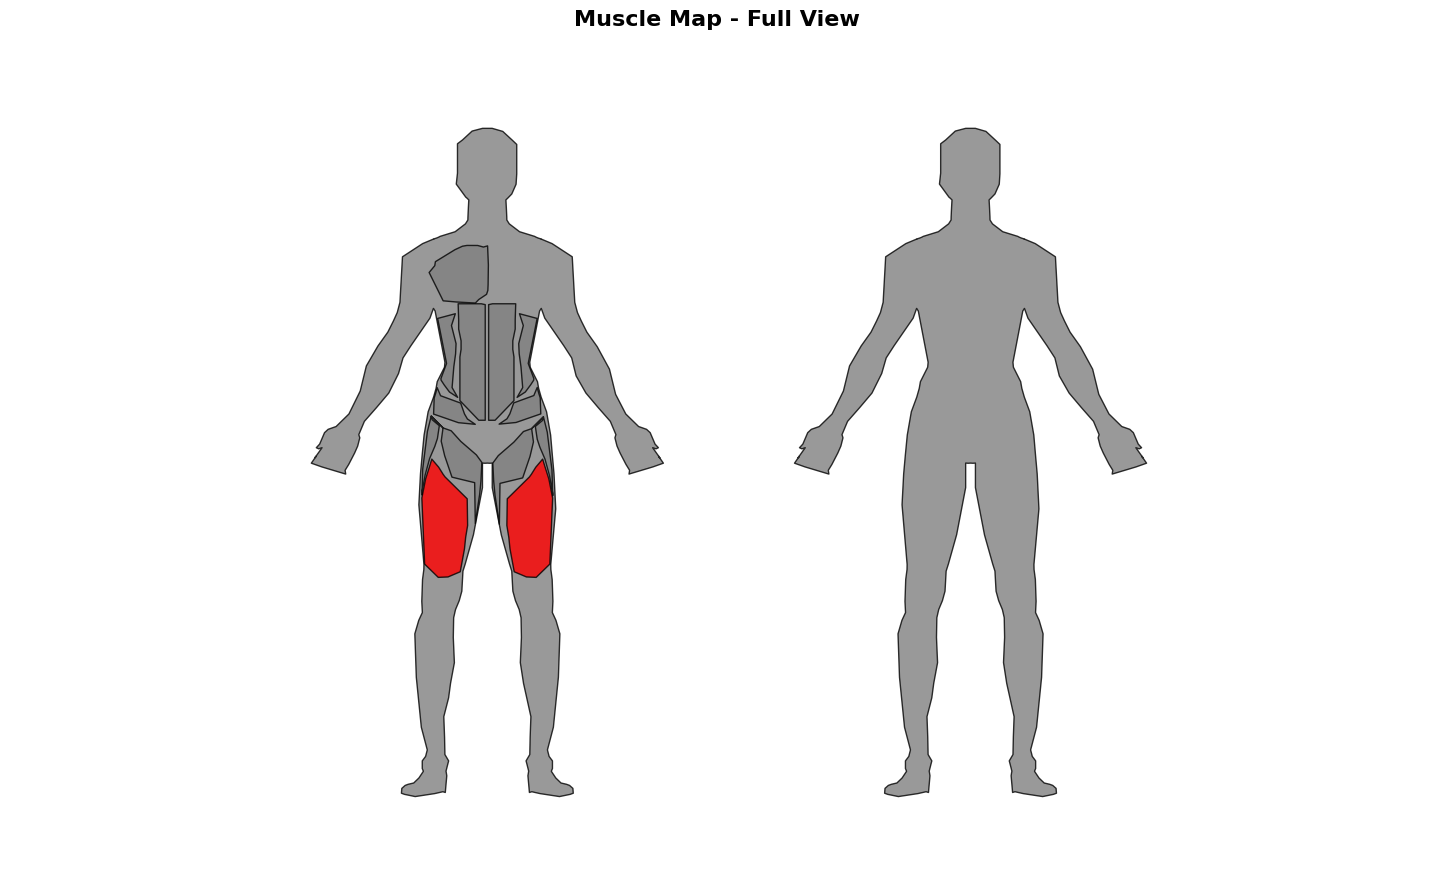

In [122]:
import json
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def parse_svg_path(d):
    """
    Parse raw SVG paths into coordinate lists.
    """
    path_data = re.findall(r"[-+]?[0-9]*\.?[0-9]+", d)
    coords = []
    for i in range(0, len(path_data), 2):
        x = float(path_data[i])
        y = float(path_data[i + 1])
        coords.append((x, -y))  # Negate y to match typical plot coordinates
    return coords

def apply_transformation(coords, transform):
    """
    Apply translation transformation to a list of coordinates.
    """
    translated_coords = [
        (x + transform.get("translateX", 0), y + transform.get("translateY", 0))
        for x, y in coords
    ]
    return translated_coords

def load_and_parse_muscle_coordinates(file_path):
    """
    Load muscle coordinates from a JSON file and apply transformations.
    """
    with open(file_path, 'r') as file:
        raw_data = json.load(file)

    parsed_data = {}
    for view, muscles in raw_data.items():
        parsed_data[view] = {}
        for muscle, paths in muscles.items():
            parsed_data[view][muscle] = []
            for path_data in paths:
                parsed_coords = parse_svg_path(path_data["path"])
                transformed_coords = apply_transformation(
                    parsed_coords, path_data.get("transform", {})
                )
                parsed_data[view][muscle].append({
                    "coords": transformed_coords,
                    "style": path_data["style"]
                })

    return parsed_data

def plot_muscle_map(muscle_data, highlighted_muscles, title, zoom_out_factor=1.5):
    """
    Plot the human body muscle map with zoom-out functionality.
    """
    fig, ax = plt.subplots(figsize=(19.8, 10.8))  # Set the window frame size

    # Adjust the limits to include the full figure range
    xlim = (-110 * zoom_out_factor, 400 * zoom_out_factor)
    ylim = (-25 * zoom_out_factor, 275 * zoom_out_factor)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_aspect('equal')
    ax.axis('off')  # Turn off axis

    patches = []  # To store all muscle group polygons
    colors = []   # To assign color for highlighting
    edge_colors = []

    for muscle, polygons in muscle_data.items():
        for polygon_data in polygons:
            polygon_coords = polygon_data["coords"]
            style = polygon_data["style"]

            # Create a polygon for the muscle group
            polygon = Polygon(polygon_coords, closed=True)
            patches.append(polygon)

            # Determine color based on muscle highlight
            if muscle in highlighted_muscles:
                colors.append('red')  # Highlighted muscle color
            else:
                colors.append(style.get("fill", "lightgrey"))  # Default or provided fill color

            edge_colors.append(style.get("stroke", "black"))

    # Add patches to the plot
    patch_collection = PatchCollection(patches, edgecolor=edge_colors, linewidths=1, facecolor=colors, alpha=0.8)
    ax.add_collection(patch_collection)

    # Add title
    ax.set_title(title, fontsize=16, weight='bold')

    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and parse muscle coordinates with transformations
    muscle_coordinates = load_and_parse_muscle_coordinates("muscle_coordinates.json")

    # Specify highlighted muscles
    highlighted_muscles_front = ["FrontQuadsRight", "FrontQuadsLeft"]

    # Plot the front view with zoom-out functionality
    plot_muscle_map(muscle_coordinates["Front"], highlighted_muscles_front, "Muscle Map - Full View", zoom_out_factor=3.0)
